********************************************************************************
					Coding Challenge for HUK Coburg
					Data Scientist Marketing
********************************************************************************


*By Irina Simankova*

Aufgabe: Modellierung der Kundenaffinität zum Abschluss einer Kfz-Versicherung

In [1]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from lib.starter import paths, formattingStyle
# set the path to the data
raw_data_path, data_path = paths()
# set the style of the plots and tables
formattingStyle()

# color RGB: 251, 211, 24, HEX: #FDD319
huk_yellow = '#FDD319'


In [2]:
# open the data
df_rest = pd.read_csv(os.path.join(raw_data_path, 'rest.csv'), sep = ';')
df_interesse = pd.read_csv(os.path.join(raw_data_path, 'interesse.csv'))
df_alter_geschlecht = pd.read_csv(os.path.join(raw_data_path, 'alter_geschlecht.csv'))

In [3]:
print(f'The shape of the rest dataset is: {df_rest.shape}')
df_rest.head(2)

The shape of the rest dataset is: (508146, 9)


,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,id
0,1,15.00,1,1-2 Year,No,"2,630.00",124.00,74,317635
1,1,28.00,0,1-2 Year,Yes,"2,630.00",125.00,213,337993


In [4]:
print(f'The shape of the alter_geschlecht dataset is: {df_alter_geschlecht.shape}')
df_alter_geschlecht.head(2)

The shape of the alter_geschlecht dataset is: (508146, 3)


,id,Geschlecht,Alter
0,170727,Male,42
1,41795,Male,24


In [5]:
print(f'The shape of the interesse dataset is: {df_interesse.shape}')
df_interesse.head(2)

The shape of the interesse dataset is: (381109, 2)


,id,Interesse
0,1,1.00
1,2,0.00


There are less obs in Interesse dataset than in the other two. 
Some customers were already approached and either took the insurance or not; and the others are those who will be approached in the future.  

In [6]:
# merge datasets rest and alter_geschlecht

df = pd.merge(df_rest, df_alter_geschlecht, on = 'id', how = 'inner')
print(f'The shape of the merged dataset is: {df.shape}')
# merge with interesse dataset
df = pd.merge(df, df_interesse, on = 'id', how = 'outer')


The shape of the merged dataset is: (508146, 11)


In [7]:
# transform Vorschaden into binary variable
df['Vorschaden'] = df['Vorschaden'].apply(lambda x: 1 if x == 'Yes' else 0)
# transform Geschlecht into binary variable
df['Geschlecht'] = df['Geschlecht'].apply(lambda x: 1 if x == 'Male' else 0)
# rename Geschlecht into Geschlecht_M
df.rename(columns = {'Geschlecht': 'Geschlecht_M'}, inplace = True)
# transform Regional_Code into integer
df['Regional_Code'] = df['Regional_Code'].astype(int)
# transform Vertriebskanal into integer
df['Vertriebskanal'] = df['Vertriebskanal'].astype(int)

cont_vars = ['Alter', 'Kundentreue', 'Jahresbeitrag']
cat_vars = ['Vorschaden', 'Geschlecht_M', 'Fahrerlaubnis', 'Alter_Fzg',	'Vorschaden', ]
quise_cat_vars = ['Vertriebskanal',  'Regional_Code'] # nominal by nature but with too many categories

# Explorative Datenanalyse

*Machen Sie sich mit dem Datensatz vertraut. Identifizieren Sie dabei mögliche Probleme sowie grundlegende statistische Zusammenhänge, welche für die anschließende Modellierung wichtig sein könnten.*

## compare samples with and without target variable 

In [8]:
df.describe(include='all')

,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,id,Geschlecht_M,Alter,Interesse
count,"508,146.00","508,146.00","508,146.00",508146,"508,146.00","508,146.00","508,146.00","508,146.00","508,146.00","508,146.00","508,146.00","381,109.00"
unique,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,1-2 Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,267015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.00,26.41,0.46,NaN,0.50,"30,554.45",111.98,154.34,"254,073.50",0.54,38.81,0.12
std,0.05,13.22,0.50,NaN,0.50,"17,146.57",54.25,83.67,"146,689.26",0.50,15.50,0.33
min,0.00,0.00,0.00,NaN,0.00,"2,630.00",1.00,10.00,1.00,0.00,20.00,0.00
25%,1.00,15.00,0.00,NaN,0.00,"24,381.00",26.00,82.00,"127,037.25",0.00,25.00,0.00
50%,1.00,28.00,0.00,NaN,1.00,"31,661.00",133.00,154.00,"254,073.50",1.00,36.00,0.00
75%,1.00,35.00,1.00,NaN,1.00,"39,403.75",152.00,227.00,"381,109.75",1.00,49.00,0.00


Rather clean data: 
- no missings
- reasonalbe range of values (no outliers) apart from Jahresbeitrag	 yet more information about car and past claims would be needed to explore in more detail

In [9]:
# only keep if Interesse is not null
dfWithTarget = pd.DataFrame(df.dropna(subset=['Interesse']))
dfWithTarget.describe(include='all')

,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,id,Geschlecht_M,Alter,Interesse
count,"381,109.00","381,109.00","381,109.00",381109,"381,109.00","381,109.00","381,109.00","381,109.00","381,109.00","381,109.00","381,109.00","381,109.00"
unique,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,1-2 Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,200316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.00,26.39,0.46,NaN,0.50,"30,564.39",112.03,154.35,"190,555.00",0.54,38.82,0.12
std,0.05,13.23,0.50,NaN,0.50,"17,213.16",54.20,83.67,"110,016.84",0.50,15.51,0.33
min,0.00,0.00,0.00,NaN,0.00,"2,630.00",1.00,10.00,1.00,0.00,20.00,0.00
25%,1.00,15.00,0.00,NaN,0.00,"24,405.00",29.00,82.00,"95,278.00",0.00,25.00,0.00
50%,1.00,28.00,0.00,NaN,1.00,"31,669.00",133.00,154.00,"190,555.00",1.00,36.00,0.00
75%,1.00,35.00,1.00,NaN,1.00,"39,400.00",152.00,227.00,"285,832.00",1.00,49.00,0.00


By eyeballing the samples seem to be balanced - contacting was likely to be randomly assigned. 

Number of unique regions: (53,)


''

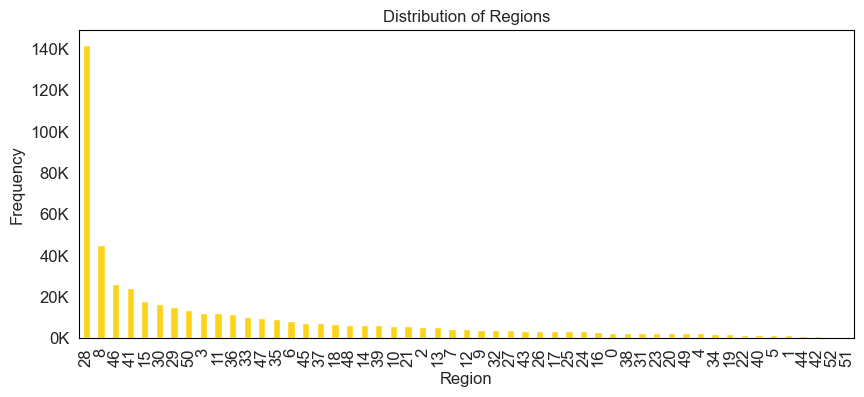

In [10]:
# Number of unique regions
print(f'Number of unique regions: {df.Regional_Code.unique().shape}')
# distribution of regions
fig, ax = plt.subplots(figsize = (10, 4))
df.Regional_Code.value_counts().plot(kind = 'bar', color = huk_yellow)
plt.title('Distribution of Regions')
plt.xlabel('Region')
plt.ylabel('Frequency')
# change value labels to K 
ax.set_yticklabels(['{:,}K'.format(int(x/1000)) for x in ax.get_yticks().tolist()])
;

Number of unique regions in dfWithTarget: (53,)


''

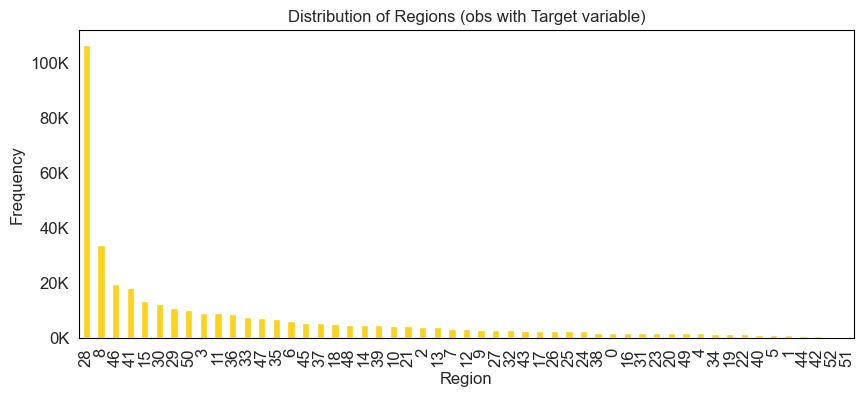

In [11]:
# Numer of unique regions dfWithTarget
print(f'Number of unique regions in dfWithTarget: {dfWithTarget.Regional_Code.unique().shape}')
# distribution of regions dfWithTarget
fig, ax = plt.subplots(figsize = (10, 4))
dfWithTarget.Regional_Code.value_counts().plot(kind = 'bar', color = huk_yellow)
plt.title('Distribution of Regions (obs with Target variable)') 
plt.xlabel('Region')
plt.ylabel('Frequency')
# change value labels to K
ax.set_yticklabels(['{:,}K'.format(int(x/1000)) for x in ax.get_yticks().tolist()])
;

Number of unique regions with Interesse == 1: (53,)


''

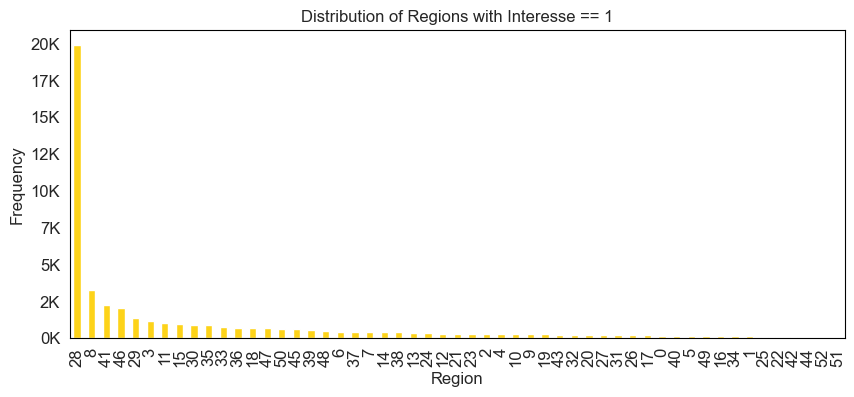

In [12]:
# Number of unique regions with Interesse == 1
print(f'Number of unique regions with Interesse == 1: {dfWithTarget[dfWithTarget.Interesse == 1].Regional_Code.unique().shape}')
# distribution of regions with Interesse == 1
fig, ax = plt.subplots(figsize = (10, 4))
dfWithTarget[dfWithTarget.Interesse == 1].Regional_Code.value_counts().plot(kind = 'bar', color = huk_yellow)
plt.title('Distribution of Regions with Interesse == 1')
plt.xlabel('Region')
plt.ylabel('Frequency')
# change value labels to K
ax.set_yticklabels(['{:,}K'.format(int(x/1000)) for x in ax.get_yticks().tolist()])
;


Number of unique Vertriebskanal: (157,)


<Axes: xlabel='Vertriebskanal'>

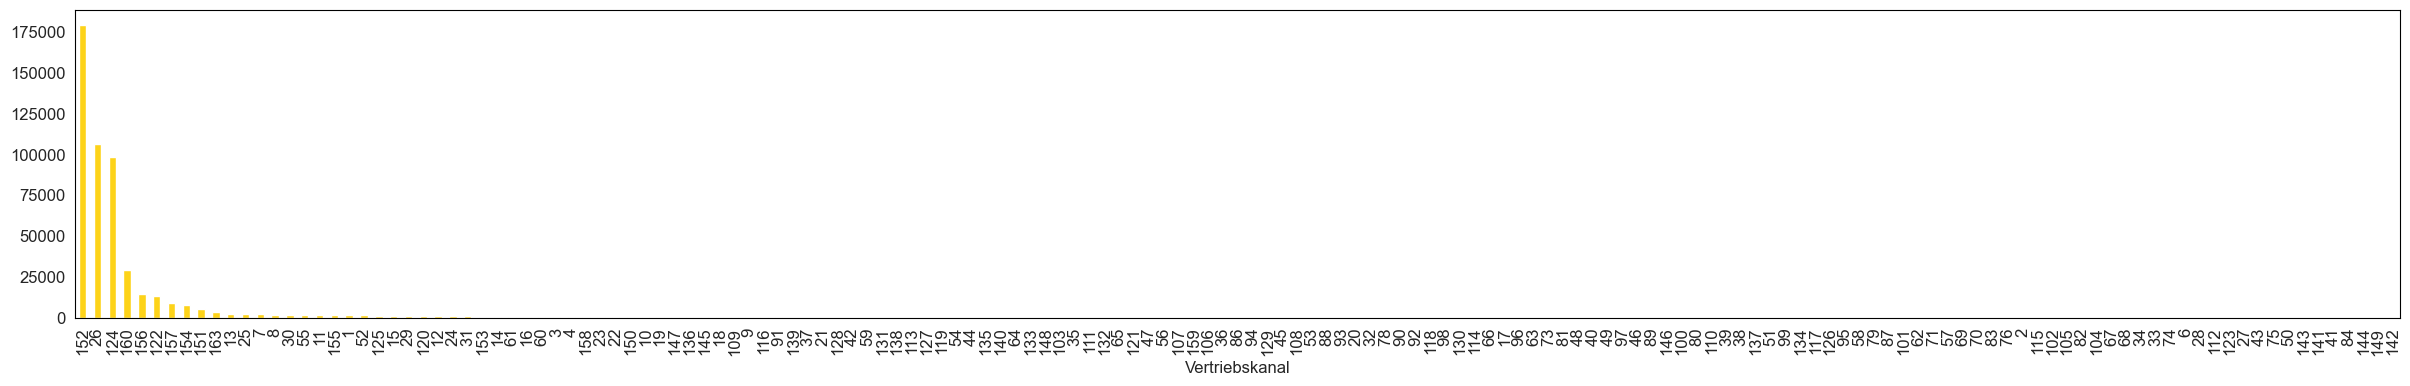

In [172]:
# Number of unique Vertriebskanal
print(f'Number of unique Vertriebskanal: {df.Vertriebskanal.unique().shape}')
# distribution of Vertriebskanal
fig, ax = plt.subplots(figsize = (30, 4))
df.Vertriebskanal.value_counts().plot(kind = 'bar', color = huk_yellow)
plt.title('Distribution of Vertriebskanal')
plt.xlabel('Vertriebskanal')
plt.ylabel('Frequency')
# change value labels to K
ax.set_yticklabels(['{:,}K'.format(int(x/1000)) for x in ax.get_yticks().tolist()])
;

Number of unique Vertriebskanal: (155,)


''

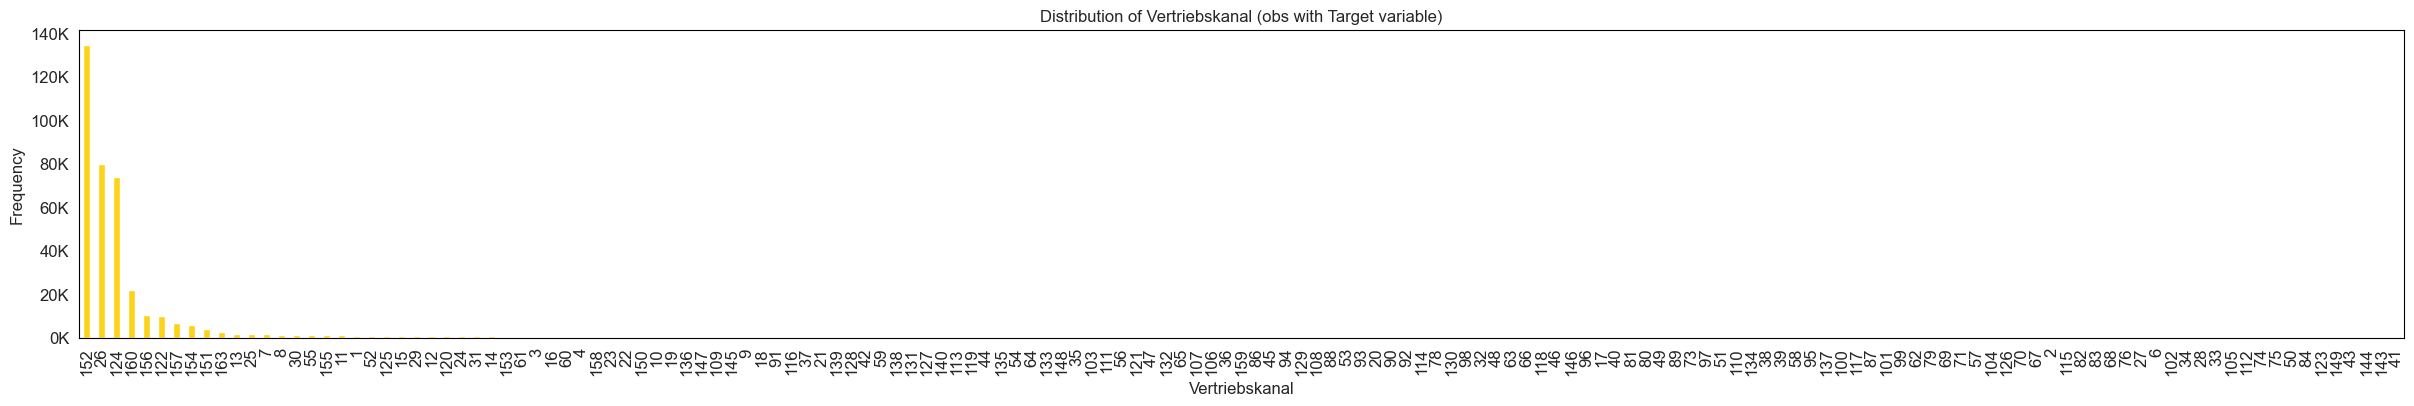

In [14]:
# Number of unique Vertriebskanal for dfWithTarget
print(f'Number of unique Vertriebskanal: {dfWithTarget.Vertriebskanal.unique().shape}')
# distribution of Vertriebskanal
fig, ax = plt.subplots(figsize = (30, 4))
dfWithTarget.Vertriebskanal.value_counts().plot(kind = 'bar', color = huk_yellow)
plt.title('Distribution of Vertriebskanal (obs with Target variable)')
plt.xlabel('Vertriebskanal')
plt.ylabel('Frequency')
# change value labels to K
ax.set_yticklabels(['{:,}K'.format(int(x/1000)) for x in ax.get_yticks().tolist()])
;

## EDA of sample with target (already contacted individuals)

In [174]:
df.Alter_Fzg.value_counts()

Alter_Fzg
1-2 Year     267015
< 1 Year     219805
> 2 Years     21326
Name: count, dtype: int64

<Axes: xlabel='Interesse', ylabel='Alter'>

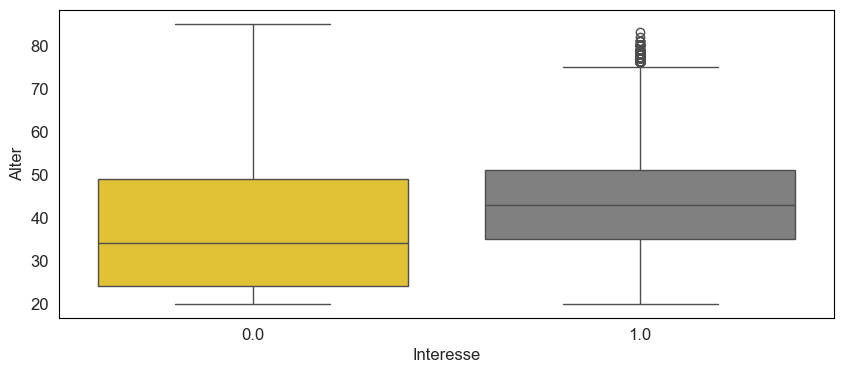

In [175]:
# plot Alter by Interesse
fig, ax = plt.subplots(figsize = (10, 4))
sns.boxplot(x = 'Interesse', y = 'Alter', data = dfWithTarget, palette = [huk_yellow, 'grey'])
    

''

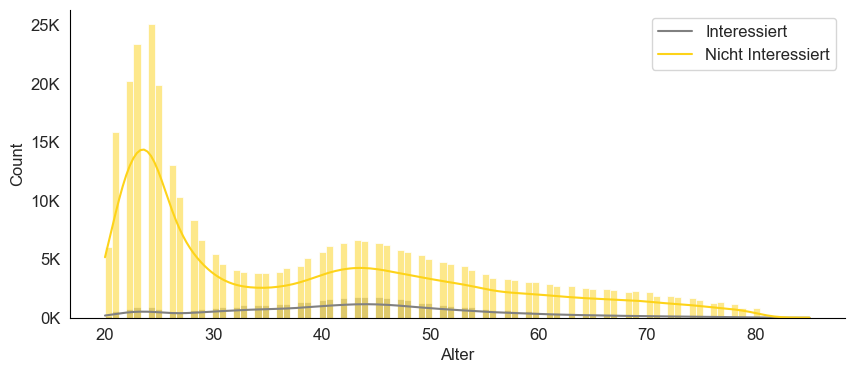

In [176]:
# plot Alter distribution  by Interesse 
fig, ax = plt.subplots(figsize = (10, 4))
sns.histplot(data = dfWithTarget, x = 'Alter', hue = 'Interesse', palette = [huk_yellow, 'grey'], kde = True)
# add legend 1 - yes, 0 - no
plt.legend(['Interessiert', 'Nicht Interessiert'])
# change value labels to K 
ax.set_yticklabels(['{:,}K'.format(int(x/1000)) for x in ax.get_yticks().tolist()])
# remove the top and right spines from plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
;

<Axes: xlabel='Interesse', ylabel='Jahresbeitrag'>

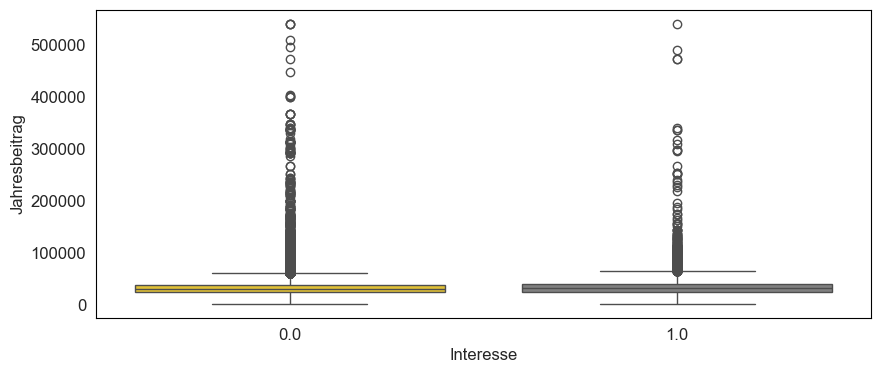

In [177]:
# plot Alter by Interesse
fig, ax = plt.subplots(figsize = (10, 4))
sns.boxplot(x = 'Interesse', y = 'Jahresbeitrag', data = dfWithTarget, palette = [huk_yellow, 'grey'])

<Axes: xlabel='Kundentreue', ylabel='Count'>

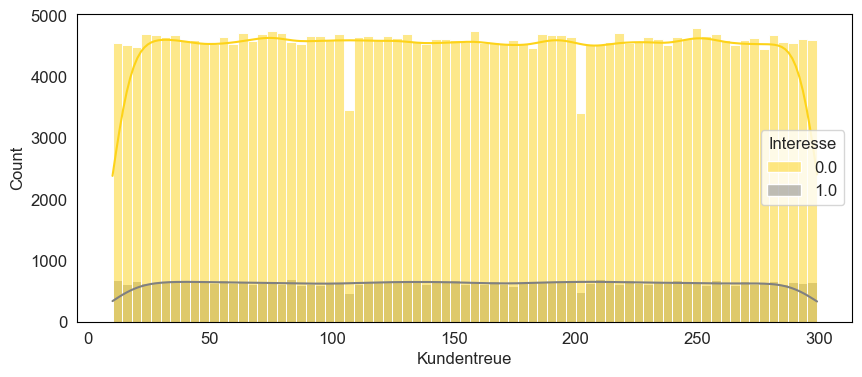

In [178]:
# plot Kundentreue distribution by Interesse
fig, ax = plt.subplots(figsize = (10, 4))
sns.histplot(data = dfWithTarget, x = 'Kundentreue', hue = 'Interesse', palette = [huk_yellow, 'grey'], kde = True)

<Axes: xlabel='Interesse', ylabel='Kundentreue'>

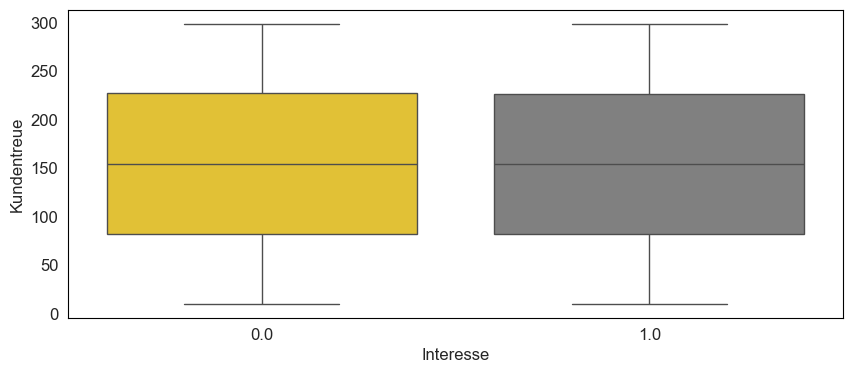

In [179]:
# plot Kundentreue by Interesse
fig, ax = plt.subplots(figsize = (10, 4))
sns.boxplot(x = 'Interesse', y = 'Kundentreue', data = dfWithTarget, palette = [huk_yellow, 'grey'])

''

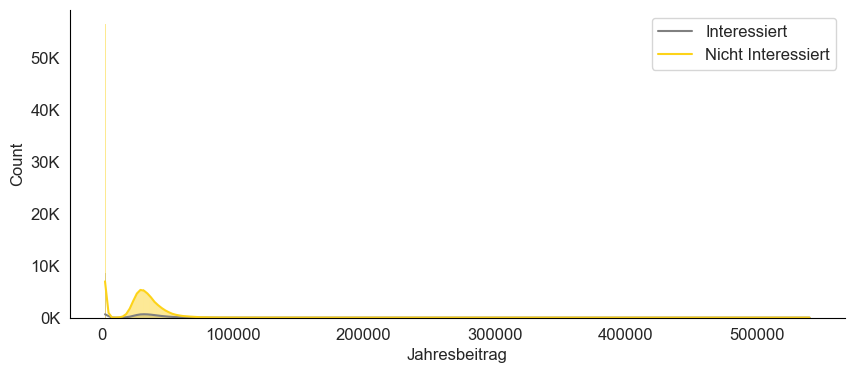

In [180]:
# plot Jahresbeitrag distribution  by Interesse 
fig, ax = plt.subplots(figsize = (10, 4))
sns.histplot(data = dfWithTarget, x = 'Jahresbeitrag', hue = 'Interesse', palette = [huk_yellow, 'grey'], kde = True)
# add legend 1 - yes, 0 - no
plt.legend(['Interessiert', 'Nicht Interessiert'])
# change value labels to K 
ax.set_yticklabels(['{:,}K'.format(int(x/1000)) for x in ax.get_yticks().tolist()])
# remove the top and right spines from plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
;

<Axes: xlabel='Interesse', ylabel='Jahresbeitrag'>

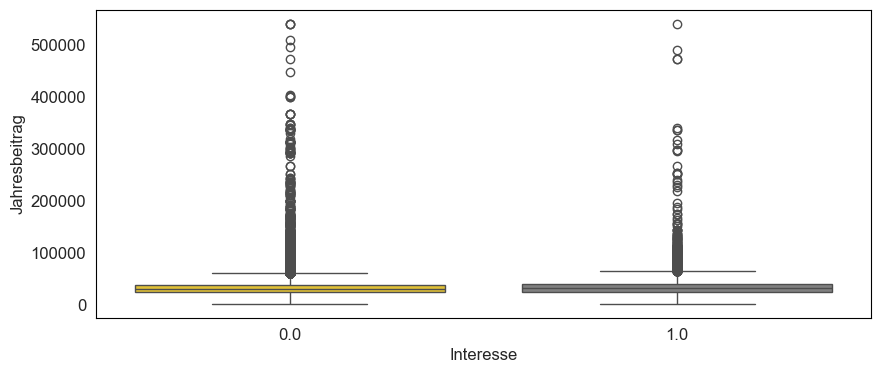

In [181]:
# plot Jahresbeitrag by Interesse
fig, ax = plt.subplots(figsize = (10, 4))
sns.boxplot(x = 'Interesse', y = 'Jahresbeitrag', data = dfWithTarget, palette = [huk_yellow, 'grey'])

array([[<Axes: xlabel='Alter', ylabel='Alter'>,
        <Axes: xlabel='Kundentreue', ylabel='Alter'>,
        <Axes: xlabel='Jahresbeitrag', ylabel='Alter'>],
       [<Axes: xlabel='Alter', ylabel='Kundentreue'>,
        <Axes: xlabel='Kundentreue', ylabel='Kundentreue'>,
        <Axes: xlabel='Jahresbeitrag', ylabel='Kundentreue'>],
       [<Axes: xlabel='Alter', ylabel='Jahresbeitrag'>,
        <Axes: xlabel='Kundentreue', ylabel='Jahresbeitrag'>,
        <Axes: xlabel='Jahresbeitrag', ylabel='Jahresbeitrag'>]],
      dtype=object)

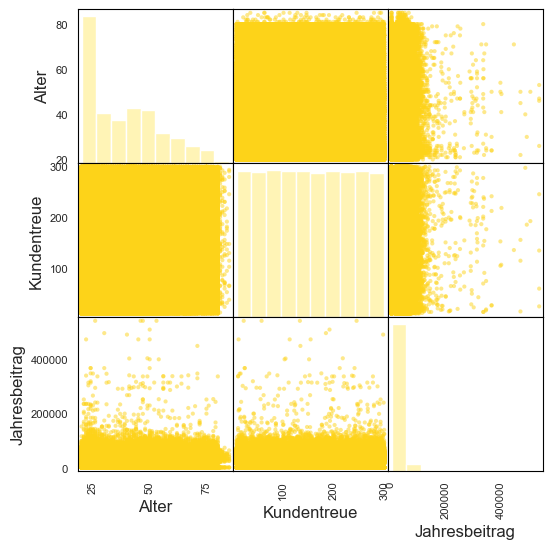

In [187]:
# plot scatter matrix

fig = plt.figure(figsize=(6, 6))
pd.plotting.scatter_matrix(dfWithTarget[cont_vars], ax=fig.gca(), color = huk_yellow)

;

Number of Interesse == 1 if Vorschaden == 0: 982
Number of Interesse == 1 if Vorversicherung == 0: 158


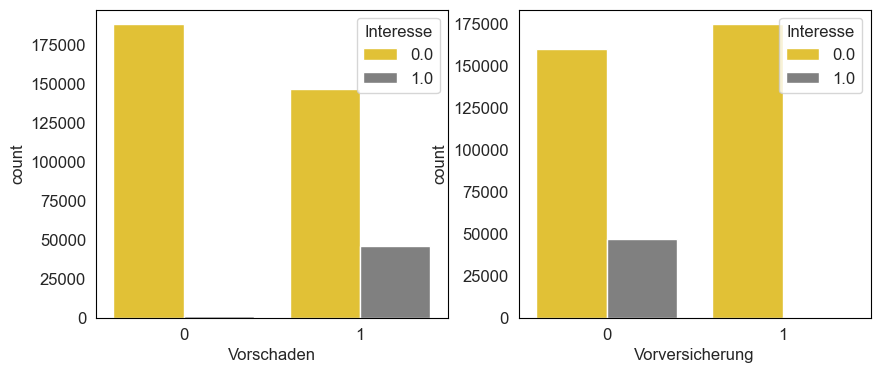

In [183]:
# plot Vorschaden and Vorversicherung by Interesse

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
sns.countplot(x = 'Vorschaden', hue = 'Interesse', data = dfWithTarget, palette = [huk_yellow, 'grey'], ax = ax[0])
sns.countplot(x = 'Vorversicherung', hue = 'Interesse', data = dfWithTarget, palette = [huk_yellow, 'grey'], ax = ax[1])

# print the number of Interesse == 1 if Vorschaden == 0 
print(f'Number of Interesse == 1 if Vorschaden == 0: {dfWithTarget[(dfWithTarget.Vorschaden == 0) & (dfWithTarget.Interesse == 1)].shape[0]}')

# print the number of Interesse == 1 if Vorvischerung == 1
print(f'Number of Interesse == 1 if Vorversicherung == 0: {dfWithTarget[(dfWithTarget.Vorversicherung == 1) & (dfWithTarget.Interesse == 1)].shape[0]}')

Percentage of Interesse == 1 for Alter_Fzg == < 1 Year: 0.043705169128445374
Percentage of Interesse == 1 for Alter_Fzg == 1-2 Year: 0.17375546636314623
Percentage of Interesse == 1 for Alter_Fzg == > 2 Years: 0.2937464859124133


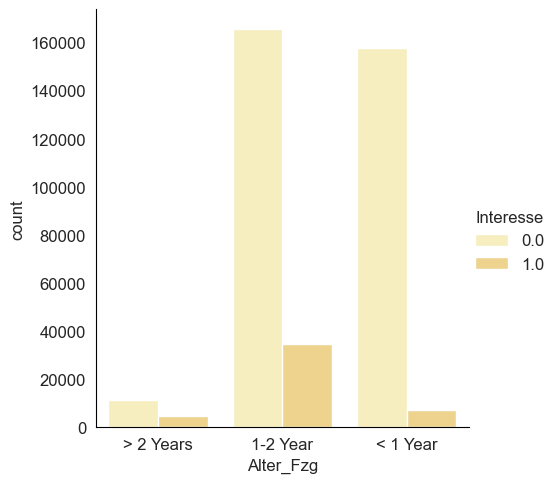

In [186]:
# plot Alt_Fzg by Interesse, Alt_Fzg is categorical with 3 levels 

sns.catplot(x='Alter_Fzg',hue='Interesse',data=dfWithTarget,kind="count")

# print the percentage of Interesse == 1 for each alter_Fzg level

for i in ['< 1 Year', '1-2 Year', '> 2 Years']:
    print(f'Percentage of Interesse == 1 for Alter_Fzg == {i}: {dfWithTarget[dfWithTarget.Alter_Fzg == i].Interesse.mean()}')


<Axes: xlabel='Alter_Fzg', ylabel='Jahresbeitrag'>

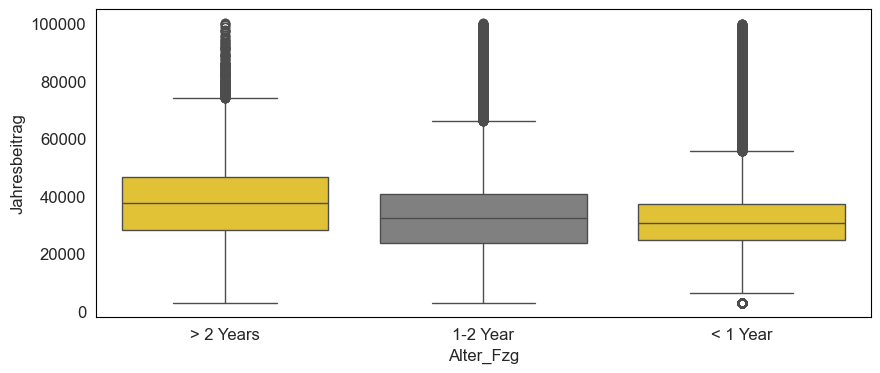

In [190]:
# plot Jahresbeitrag by Alter_Fzg

fig, ax = plt.subplots(figsize = (10, 4))
sns.boxplot(x = 'Alter_Fzg', y = 'Jahresbeitrag', data = dfWithTarget[dfWithTarget.Jahresbeitrag < 100000], palette = [huk_yellow, 'grey'])
    

Based on the EDA several intuitive conclustion can be made: 

- individuals most interested are between 40 to 50 yo. An average intersted is older than an average not interested. 
- an individual who had a Vorschaden is more likely to be interested than one who did not have any
- an individual without Vorversicherung is more likely to be interested than one who has it -This is a bit strange that there are at all individuals with insurance who are interested in the offer - **does the offer differ from what they have?**
- the older the car, the more linkely to be interested in the offer

# Feature engineering

*Bereiten Sie, soweit für ihre Modellierung nötig, die Variablen geeignet auf..*

- If there was more information provided about regions, features such as higher level region, urban/ rural, public transport availability could be generated.
- The same holds for Vertriebskanal: more info could allow for features. 

In [103]:
# make id an index
dfWithTarget.set_index('id', inplace = True)

In [104]:
# categorize Alter_Fzg creating three binary vars -one hot encoding
dfWithTarget['Alter_Fzg_1'] = dfWithTarget['Alter_Fzg'].apply(lambda x: 1 if x == '< 1 Year' else 0)
dfWithTarget['Alter_Fzg_2'] = dfWithTarget['Alter_Fzg'].apply(lambda x: 1 if x == '1-2 Year' else 0)
dfWithTarget['Alter_Fzg_3'] = dfWithTarget['Alter_Fzg'].apply(lambda x: 1 if x == '> 2 Years' else 0)

# drop Alter_Fzg
dfWithTarget.drop(columns = 'Alter_Fzg', inplace = True)

dfWithTarget.head()

,Fahrerlaubnis,Regional_Code,Vorversicherung,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,Geschlecht_M,Alter,Interesse,Alter_Fzg_1,Alter_Fzg_2,Alter_Fzg_3
id,,,,,,,,,,,,,
1,1,28,0,1,"40,454.00",26,217,1,44,1.00,0,0,1
2,1,3,0,0,"33,536.00",26,183,1,76,0.00,0,1,0
3,1,28,0,1,"38,294.00",26,27,1,47,1.00,0,0,1
4,1,11,1,0,"28,619.00",152,203,1,21,0.00,1,0,0
5,1,41,1,0,"27,496.00",152,39,0,29,0.00,1,0,0


In [105]:
# make a variable for top 5 regions and other for the rest
top_regions = dfWithTarget.Regional_Code.value_counts().head(5).index
dfWithTarget['Regional_Code'] = dfWithTarget['Regional_Code'].apply(lambda x: x if x in top_regions else 'Other')
dfWithTarget = pd.get_dummies(dfWithTarget, columns = ['Regional_Code'])
dfWithTarget.columns

Index(['Fahrerlaubnis', 'Vorversicherung', 'Vorschaden', 'Jahresbeitrag',
       'Vertriebskanal', 'Kundentreue', 'Geschlecht_M', 'Alter', 'Interesse',
       'Alter_Fzg_1', 'Alter_Fzg_2', 'Alter_Fzg_3', 'Regional_Code_8',
       'Regional_Code_15', 'Regional_Code_28', 'Regional_Code_41',
       'Regional_Code_46', 'Regional_Code_Other'],
      dtype='object')

In [106]:
# make a variable for top 5 Vertriebskanal and other for the rest
top_vertriebskanal = dfWithTarget.Vertriebskanal.value_counts().head(5).index
dfWithTarget['Vertriebskanal'] = dfWithTarget['Vertriebskanal'].apply(lambda x: x if x in top_vertriebskanal else 'Other')
dfWithTarget = pd.get_dummies(dfWithTarget, columns = ['Vertriebskanal'])
dfWithTarget.columns


Index(['Fahrerlaubnis', 'Vorversicherung', 'Vorschaden', 'Jahresbeitrag',
       'Kundentreue', 'Geschlecht_M', 'Alter', 'Interesse', 'Alter_Fzg_1',
       'Alter_Fzg_2', 'Alter_Fzg_3', 'Regional_Code_8', 'Regional_Code_15',
       'Regional_Code_28', 'Regional_Code_41', 'Regional_Code_46',
       'Regional_Code_Other', 'Vertriebskanal_26', 'Vertriebskanal_124',
       'Vertriebskanal_152', 'Vertriebskanal_156', 'Vertriebskanal_160',
       'Vertriebskanal_Other'],
      dtype='object')

In [108]:
# save data to csv file

file = os.path.join(data_path, 'df.csv')
dfWithTarget.to_csv(file)